## Loading data into dataframe for ease of access

In [17]:

import os
import pandas as pd
path_, filename_, category_, article_or_summary_ = [],[],[],[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_.append(os.path.join(dirname, filename))
        filename_.append(filename)
        category_.append(dirname.split("/")[-1])
        article_or_summary_.append(dirname.split("/")[-2])

In [18]:
df = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_}, columns=["path", "filename", "category", "article_or_summary"])
df

,path,filename,category,article_or_summary
0,/kaggle/input/universal-sentence-encoder/tenso...,saved_model.pb,2,universal-sentence-encoder
1,/kaggle/input/universal-sentence-encoder/tenso...,variables.index,variables,2
2,/kaggle/input/universal-sentence-encoder/tenso...,variables.data-00000-of-00001,variables,2
3,/kaggle/input/bbc-news-summary/BBC News Summar...,361.txt,politics,Summaries
4,/kaggle/input/bbc-news-summary/BBC News Summar...,245.txt,politics,Summaries
...,...,...,...,...
8898,/kaggle/input/bbc-news-summary/bbc news summar...,380.txt,business,News Articles
8899,/kaggle/input/bbc-news-summary/bbc news summar...,192.txt,business,News Articles
8900,/kaggle/input/bbc-news-summary/bbc news summar...,248.txt,business,News Articles
8901,/kaggle/input/bbc-news-summary/bbc news summar...,004.txt,business,News Articles


In [19]:
!pip install cufflinks
import plotly_express as pe
import cufflinks as cf

cf.go_offline()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



## Distribution of Number of Articles in Each Category

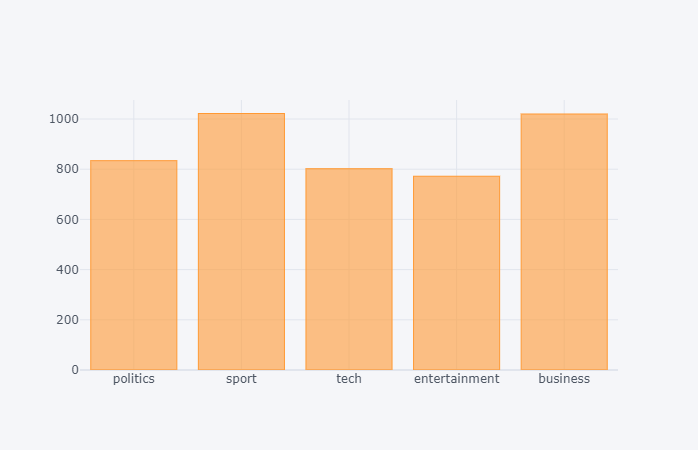

In [20]:
from collections import Counter

ct = Counter(df[df['article_or_summary']=="News Articles"]["category"])
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='bar', x='category', y='value')

## Distribution of Category and its Values

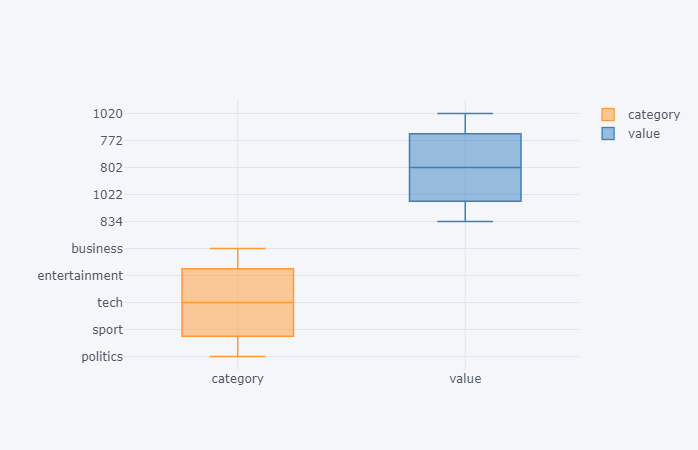

In [21]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='box')

## Distribution Size of Each Category

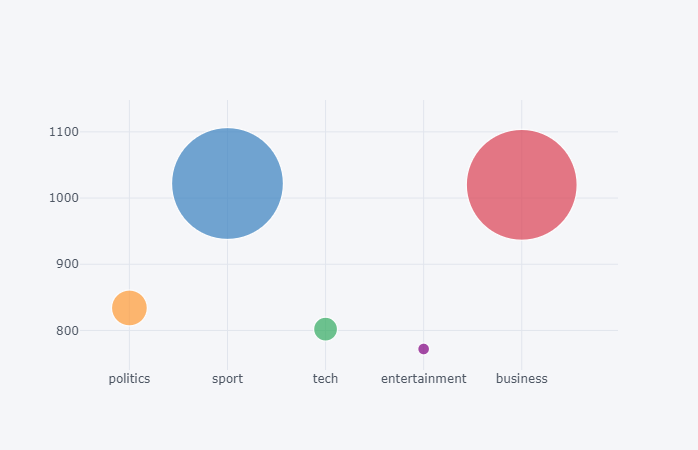

In [22]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='bubble', x='category', y='value', size='value')

## Coverage Ratio of Each Category

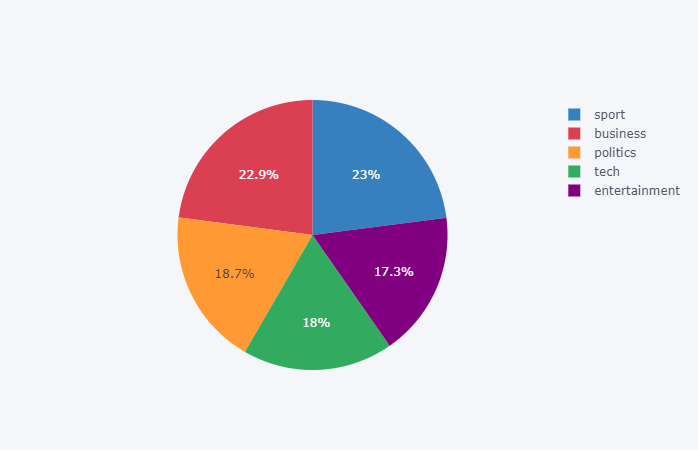

In [23]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='pie', labels="category", values='value')

# # PreProcessing

# Sentence Tokenization

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re

In [25]:
def read_article(text):        
    sentences =[]        
    sentences = sent_tokenize(text)    
    for sentence in sentences:        
        sentence.replace("[^a-zA-Z0-9]"," ")     
    return sentences

In [26]:
file_path = df[df['article_or_summary']=='News Articles'].iloc[0]['path']
with open(file_path, "r") as f:
    article = f.read()

In [27]:
sent_tok = read_article(article)
sent_tok

["Budget to set scene for election\n\nGordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT.",
 'He is expected to stress the importance of continued economic stability, with low unemployment and interest rates.',
 'The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000.',
 'But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.',
 'Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about £2bn to spare.',
 "- Increase in the stamp duty threshold from £60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos.",
 'Ten years ago, buyers had a m

## Spell Correction 

In [28]:
from textblob import TextBlob
mod_sent = []
for tok in sent_tok:
    blob_obj = TextBlob(tok)
    correct_sent = str(blob_obj.correct())
    print(f"\033[94m Original Token : {tok} \033[0m")
    print(f"\033[92m Corrected Token: {correct_sent} \033[92m")
    mod_sent.append(correct_sent)

 Original Token : Budget to set scene for election

Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. 
 Corrected Token: Budget to set scene for election

Gordon Grown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. 
 Original Token : He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. 
 Corrected Token: He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. 
 Original Token : The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. 
 Corrected Token: The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. 
 Original Token : But the Conservatives and Lib Dems insist voters face higher taxes and more means-te

## Modified Sentences

In [29]:
" ".join(mod_sent)

'Budget to set scene for election\n\nGordon Grown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Rib Gems insist voters face higher taxes and more means-testing under Labour. Treasury officials have said there will not be a pre-election giveaway, but Or Grown is thought to have about £in to spare. - Increase in the stamp duty threshold from £60,000 \n - A freeze on petrol duty \n - In extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifesto. Men years ago, buyers had a much greater chance of avo

# #  Sentence Similarity

In [30]:
import tensorflow_hub as hub

embed = hub.load("/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2")

def sentence_similarity(sent1,sent2,embed):  
    A = embed([sent1])[0]
    B = embed([sent2])[0]
    return 1 - (np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

Sample Output of how the distance looks like between two sample Sentences

In [31]:
print(f"\033[92m Sentence 1 : {mod_sent[0]}")
print(f"\033[92m Sentence 2 : {mod_sent[1]}")
print(f"\033[92m Similarity Score : {sentence_similarity(mod_sent[0], mod_sent[1], embed)}")

 Sentence 1 : Budget to set scene for election

Gordon Grown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT.
 Sentence 2 : He is expected to stress the importance of continued economic stability, with low unemployment and interest rates.
 Similarity Score : 0.7819880843162537


Computing Similarity Matrix
    
    Given Sentences: [sent1, sent2,....sentN]
    For all Senetences compution Correlation distance
    All these distance are stored at its Sentences index position
    
    [dist(sent1, sent1),...........,(sent1, sentN)]
    [                    .                         ]
    [                    .                         ]
    [                    .                         ]
    [                    .                         ]
    [                    .                         ]
    [                    .                         ]
    [dict(sentN, Sent1),............(SentN, SentN) ]
    

In [32]:
def build_similarity_matrix(sentences,embeds):
    similarity_matrix = np.zeros((len(sentences),len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1!=idx2:
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2],embeds)
    return similarity_matrix

In [33]:
sim_mat = build_similarity_matrix(mod_sent, embed)

Below is the Graphical representation of Similar Sentences who passes the threshold value and how they are connected in 2D Space.

Condition Used:

    Given Sentence A, B and Threshold,
    If (np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))) >= Threshold 
    Then Show Edge between Sent A, B
    Else Do not add Edge

In [34]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
from bokeh.io import output_notebook, show, save

output_notebook()

g = nx.Graph()

for i in range(sim_mat.shape[0]):
    for j in range(sim_mat.shape[1]):
        if sim_mat[i][j] >=.9:
            g.add_edge(i, j)

HOVER_TOOLTIPS = [("sent_tok", "@index")]
plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1))

network_graph = from_networkx(g, networkx.spring_layout, scale=7, center=(0, 0))
network_graph.node_renderer.glyph = Circle(size=15,fill_color='green')
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
plot.renderers.append(network_graph)
show(plot)

Loading BokehJS ...

# # Summarization

In [35]:
file_path_summary = df[df['article_or_summary']=='Summaries'].iloc[0]['path']
with open(file_path_summary, "r") as f:
    actual_summary = f.read()

In [36]:
def generate_summary(text,top_n,embeds):
    summarize_text = []  
    sentences = read_article(text)           
    sentence_similarity_matrix = build_similarity_matrix(sentences,embeds)  
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph) 
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
    for i in range(top_n):
        summarize_text.append(ranked_sentences[i][1]) 
    return " ".join(summarize_text)

In [37]:
Original_Text = " ".join(mod_sent)
Summarized_Text = generate_summary(Original_Text, top_n=5, embeds=embed)

In [38]:
Original_Text

'Budget to set scene for election\n\nGordon Grown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Rib Gems insist voters face higher taxes and more means-testing under Labour. Treasury officials have said there will not be a pre-election giveaway, but Or Grown is thought to have about £in to spare. - Increase in the stamp duty threshold from £60,000 \n - A freeze on petrol duty \n - In extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifesto. Men years ago, buyers had a much greater chance of avo

In [39]:
Summarized_Text

'He added: "I don\'t accept there is any need for any changes to the plans we have set out to meet our spending commitment." He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. "But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way." Treasury officials have said there will not be a pre-election giveaway, but Or Grown is thought to have about £in to spare. Men years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Tales alone, selling for less than £60,000.'

In [40]:
actual_summary

'- Increase in the stamp duty threshold from £60,000 - A freeze on petrol duty - An extension of tax credit scheme for poorer families - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifestos.The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000.The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a "classic Labour stealth tax".Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government\'s tax take.Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased.For the Lib Dems David Laws said: "The chancellor will no doubt tell us today how wonderfully the economy is doing," he said.The Liberal Democrats unveiled their own proposals to raise the st

# # Validation

# Bleu Score

In [41]:
import nltk

hypothesis = Summarized_Text
reference = actual_summary
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore}")

BLEUscore : 0.3105109744864834


Below is the definition same has been used for the above methods
    
    def sentence_similarity(sent1,sent2,embed):  
        A = embed([sent1])[0]
        B = embed([sent2])[0]
        return 1 - (np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

In [42]:
print(f"Senetence Similarity Score : {sentence_similarity(Summarized_Text, actual_summary, embed)}")

Senetence Similarity Score : 0.5627625286579132


This gives us the better score comparitive to the Bleu Score for our use case i.e ~56.3%